In [51]:
from google.colab import drive
drive.mount('/content/drive')
# drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
cd /content/drive/MyDrive/EVA6/session6

/content/drive/MyDrive/EVA6/session6


In [53]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [54]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-6.9, 6.9), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [55]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [56]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
from model import network_model
norm_arg = 'batch'
Net = network_model(norm_arg)

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = Net.to(device)
summary(model, input_size=(1, 28, 28))

Batch Normalisation is selected
cuda


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14            [-1, 8,

/content/drive/My Drive/EVA6/session6/model.py:93: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch,norm_arg):
  model.train()
  #pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  epoch_loss = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    # get samples
    data, target = data.to(device), target.to(device)
    #print("target size:",target.size())
    #target = target.squeeze(1)
    #print("target size2:",target.size())
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)
    #print("y_pred size:",y_pred.size())
    y_pred = y_pred.squeeze(-1)
    y_pred = y_pred.squeeze(-1)
    #print("y_pred size2:",y_pred.size())
    # Calculate loss
    actual_loss = F.nll_loss(y_pred, target)
    #print("initial loss",actual_loss)

    l2_reg = 0
    l2_lambda = 0.001
    for W in model.parameters():
      l2_reg = l2_reg + W.norm(2)
    l2_reg = l2_lambda*l2_reg
    #print("l2 loss",l2_reg)
    
    l1_reg = 0
    l1_lambda = 0.0001
    for W in model.parameters():
      l1_reg = l1_reg + W.abs().sum()
    l1_reg = l1_lambda*l1_reg
    #print("l1 loss",l1_reg)
    if(norm_arg == 'batch'):
      loss  = actual_loss  + l2_reg + l1_reg
    if(norm_arg == 'layer'):
      loss  = actual_loss  + l2_reg 
    if(norm_arg == 'group'):
      loss  = actual_loss  + l1_reg
    
		
    #loss  = actual_loss
    #print("total_loss",loss)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    epoch_loss += loss
    #pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  
  return epoch_loss/len(train_loader.dataset),100*correct/processed

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    epoch_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = output.squeeze(-1)
            output = output.squeeze(-1)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    """
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    """
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss,100. * correct / len(test_loader.dataset)

In [11]:
#model =  Net_batch().to(device)
#model =  Net_group().to(device)
#model =  Net_layer().to(device)
norm_arg = 'batch'
Net = network_model(norm_arg)
model =  Net.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,dampening=0, weight_decay =0, nesterov=False)
EPOCHS = 25
batch_train_losses = []
batch_test_losses = []
batch_train_accuracy = []
batch_test_accuracy = []
for epoch in range(EPOCHS):
    #print("EPOCH:", epoch)
    print("-----------------------------------------------------------------------------------------------------------------------------")
    epoch_train_losses,epoch_train_accuracy = train(model, device, train_loader, optimizer, epoch,norm_arg)
    epoch_test_losses,epoch_test_accuracy = test(model, device, test_loader)
    batch_train_losses.append(float(epoch_train_losses))
    batch_test_losses.append(float(epoch_test_losses))
    batch_train_accuracy.append(epoch_train_accuracy)
    batch_test_accuracy.append(epoch_test_accuracy)
    print("epoch no: ",epoch+1," epoch_train_accuracy: ",epoch_train_accuracy," epoch_test_accuracy: ",epoch_test_accuracy)
    #print("epoch no: ",epoch+1," epoch_train_losses: ",float(epoch_train_losses)," epoch_test_losses: ",float(epoch_test_losses))
    #print('batch_train_losses',batch_train_losses)
    #print('batch_test_losses',batch_test_losses)
    #print('batch_train_accuracy',batch_train_accuracy)
    #print('batch_test_accuracy',batch_test_accuracy)


Batch Normalisation is selected
-----------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/My Drive/EVA6/session6/model.py:93: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


epoch no:  1  epoch_train_accuracy:  80.91666666666667  epoch_test_accuracy:  96.63
-----------------------------------------------------------------------------------------------------------------------------
epoch no:  2  epoch_train_accuracy:  97.26666666666667  epoch_test_accuracy:  98.35
-----------------------------------------------------------------------------------------------------------------------------
epoch no:  3  epoch_train_accuracy:  97.97833333333334  epoch_test_accuracy:  98.68
-----------------------------------------------------------------------------------------------------------------------------
epoch no:  4  epoch_train_accuracy:  98.14833333333333  epoch_test_accuracy:  98.44
-----------------------------------------------------------------------------------------------------------------------------
epoch no:  5  epoch_train_accuracy:  98.325  epoch_test_accuracy:  99.01
---------------------------------------------------------------------------------------

In [12]:
#model =  Net_batch().to(device)
#model =  Net_group().to(device)
#model =  Net_layer().to(device)
norm_arg = 'layer'
Net = network_model(norm_arg)
model =  Net.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,dampening=0, weight_decay =0, nesterov=False)
EPOCHS = 25
layer_train_losses = []
layer_test_losses = []
layer_train_accuracy = []
layer_test_accuracy = []
for epoch in range(EPOCHS):
    #print("EPOCH:", epoch)
    print("-----------------------------------------------------------------------------------------------------------------------------")
    epoch_train_losses,epoch_train_accuracy = train(model, device, train_loader, optimizer, epoch,norm_arg)
    epoch_test_losses,epoch_test_accuracy = test(model, device, test_loader)
    layer_train_losses.append(float(epoch_train_losses))
    layer_test_losses.append(float(epoch_test_losses))
    layer_train_accuracy.append(epoch_train_accuracy)
    layer_test_accuracy.append(epoch_test_accuracy)
    print("epoch no: ",epoch+1," epoch_train_accuracy: ",epoch_train_accuracy," epoch_test_accuracy: ",epoch_test_accuracy)
    #print("epoch no: ",epoch+1," epoch_train_losses: ",float(epoch_train_losses)," epoch_test_losses: ",float(epoch_test_losses))
    #print('layer_train_losses',layer_train_losses)
    #print('layer_test_losses',layer_test_losses)
    #print('layer_train_accuracy',layer_train_accuracy)
    #print('layer_test_accuracy',layer_test_accuracy)


Layer Normalisation is selected
-----------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/My Drive/EVA6/session6/model.py:177: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


epoch no:  1  epoch_train_accuracy:  80.33166666666666  epoch_test_accuracy:  96.25
-----------------------------------------------------------------------------------------------------------------------------
epoch no:  2  epoch_train_accuracy:  96.22166666666666  epoch_test_accuracy:  97.51
-----------------------------------------------------------------------------------------------------------------------------
epoch no:  3  epoch_train_accuracy:  97.30833333333334  epoch_test_accuracy:  98.52
-----------------------------------------------------------------------------------------------------------------------------
epoch no:  4  epoch_train_accuracy:  97.63666666666667  epoch_test_accuracy:  98.52
-----------------------------------------------------------------------------------------------------------------------------
epoch no:  5  epoch_train_accuracy:  97.98666666666666  epoch_test_accuracy:  98.97
----------------------------------------------------------------------------

In [13]:
#model =  Net_batch().to(device)
#model =  Net_group().to(device)
#model =  Net_layer().to(device)
norm_arg = 'group'
Net = network_model(norm_arg)
model =  Net.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,dampening=0, weight_decay =0, nesterov=False)
EPOCHS = 25
group_train_losses = []
group_test_losses = []
group_train_accuracy = []
group_test_accuracy = []
for epoch in range(EPOCHS):
    #print("EPOCH:", epoch)
    print("-----------------------------------------------------------------------------------------------------------------------------")
    epoch_train_losses,epoch_train_accuracy = train(model, device, train_loader, optimizer, epoch,norm_arg)
    epoch_test_losses,epoch_test_accuracy = test(model, device, test_loader)
    group_train_losses.append(float(epoch_train_losses))
    group_test_losses.append(float(epoch_test_losses))
    group_train_accuracy.append(epoch_train_accuracy)
    group_test_accuracy.append(epoch_test_accuracy)
    print("epoch no: ",epoch+1," epoch_train_accuracy: ",epoch_train_accuracy," epoch_test_accuracy: ",epoch_test_accuracy)
    #print("epoch no: ",epoch+1," epoch_train_losses: ",float(epoch_train_losses)," epoch_test_losses: ",float(epoch_test_losses))
    #print('group_train_losses',group_train_losses)
    #print('group_test_losses',group_test_losses)
    #print('group_train_accuracy',group_train_accuracy)
    #print('group_test_accuracy',group_test_accuracy)


Group Normalisation is selected
-----------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/My Drive/EVA6/session6/model.py:261: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


epoch no:  1  epoch_train_accuracy:  79.31833333333333  epoch_test_accuracy:  96.5
-----------------------------------------------------------------------------------------------------------------------------
epoch no:  2  epoch_train_accuracy:  96.17333333333333  epoch_test_accuracy:  98.09
-----------------------------------------------------------------------------------------------------------------------------
epoch no:  3  epoch_train_accuracy:  97.25  epoch_test_accuracy:  98.44
-----------------------------------------------------------------------------------------------------------------------------
epoch no:  4  epoch_train_accuracy:  97.78833333333333  epoch_test_accuracy:  98.58
-----------------------------------------------------------------------------------------------------------------------------
epoch no:  5  epoch_train_accuracy:  98.00333333333333  epoch_test_accuracy:  98.88
-----------------------------------------------------------------------------------------

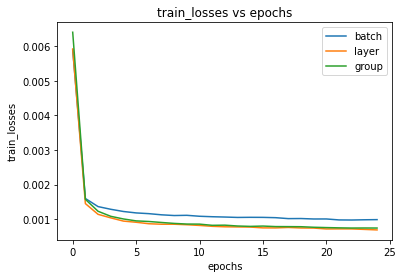

In [14]:
import matplotlib.pyplot as plt
plt.plot(batch_train_losses, label = "batch")
plt.plot(layer_train_losses, label = "layer")
plt.plot(group_train_losses, label = "group")

plt.xlabel('epochs')
plt.ylabel('train_losses')
plt.title('train_losses vs epochs')
plt.legend()
plt.show()

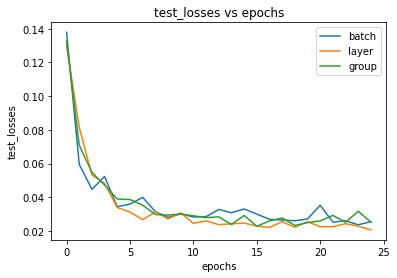

In [15]:
import matplotlib.pyplot as plt
plt.plot(batch_test_losses, label = "batch")
plt.plot(layer_test_losses, label = "layer")
plt.plot(group_test_losses, label = "group")

plt.xlabel('epochs')
plt.ylabel('test_losses')
plt.title('test_losses vs epochs')
plt.legend()
plt.show()

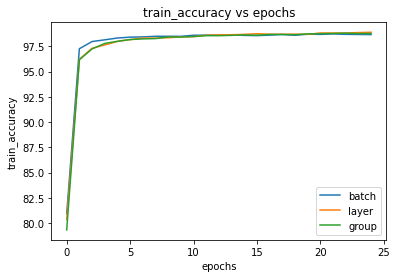

In [16]:
import matplotlib.pyplot as plt
plt.plot(batch_train_accuracy, label = "batch")
plt.plot(layer_train_accuracy, label = "layer")
plt.plot(group_train_accuracy, label = "group")

plt.xlabel('epochs')
plt.ylabel('train_accuracy')
plt.title('train_accuracy vs epochs')
plt.legend()
plt.show()

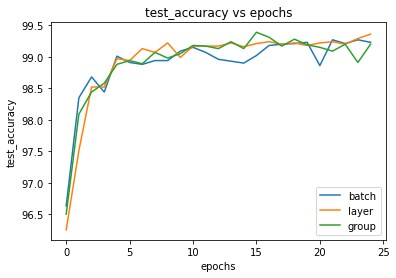

In [17]:
import matplotlib.pyplot as plt
plt.plot(batch_test_accuracy, label = "batch")
plt.plot(layer_test_accuracy, label = "layer")
plt.plot(group_test_accuracy, label = "group")

plt.xlabel('epochs')
plt.ylabel('test_accuracy')
plt.title('test_accuracy vs epochs')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Batch Normalisation is selected


/content/drive/My Drive/EVA6/session6/model.py:93: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


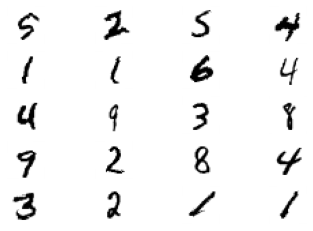

In [79]:
dataiter = iter(train_loader)
images, labels = dataiter.next()


misclssified_images_batch = []
norm_arg = 'batch'
Net = network_model(norm_arg)
model =  Net.to(device)
for index in range(1, 1000):
    
    label = int(labels[index])

    image = torch.unsqueeze(images[index], 0).to(device)
    
    prediction = model(image)
    prediction = prediction.squeeze(-1)
    prediction = prediction.squeeze(-1)
    prediction = int(torch.argmax(prediction))
    #print("prediction",prediction)
    #print("label",label)
    if(prediction != label):
      misclssified_images_batch.append(image)
    #print("len(misclssified_images_batch)",len(misclssified_images_batch))
    if(len(misclssified_images_batch)>=20):
      break;
    
figure = plt.figure()
num_of_images = 20
#misclssified_images_batch = misclssified_images_batch.numpy()
for index in range(1, num_of_images + 1):
    plt.subplot(5, 4, index)
    plt.axis('off')
    image = misclssified_images_batch[index-1]
    image = image.cpu().numpy()
    #print("test",misclssified_images_batch[index].size())
    plt.imshow(image.squeeze(), cmap='gray_r')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Layer Normalisation is selected


/content/drive/My Drive/EVA6/session6/model.py:177: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


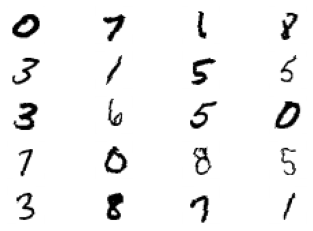

In [80]:
dataiter = iter(train_loader)
images, labels = dataiter.next()


misclssified_images_layer = []
norm_arg = 'layer'
Net = network_model(norm_arg)
model =  Net.to(device)
for index in range(1, 1000):
    
    label = int(labels[index])

    image = torch.unsqueeze(images[index], 0).to(device)
    
    prediction = model(image)
    prediction = prediction.squeeze(-1)
    prediction = prediction.squeeze(-1)
    prediction = int(torch.argmax(prediction))
    #print("prediction",prediction)
    #print("label",label)
    if(prediction != label):
      misclssified_images_layer.append(image)
    #print("len(misclssified_images_batch)",len(misclssified_images_batch))
    if(len(misclssified_images_layer)>=20):
      break;
    
figure = plt.figure()
num_of_images = 20
#misclssified_images_batch = misclssified_images_batch.numpy()
for index in range(1, num_of_images + 1):
    plt.subplot(5, 4, index)
    plt.axis('off')
    image = misclssified_images_layer[index-1]
    image = image.cpu().numpy()
    #print("test",misclssified_images_batch[index].size())
    plt.imshow(image.squeeze(), cmap='gray_r')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Group Normalisation is selected


/content/drive/My Drive/EVA6/session6/model.py:261: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


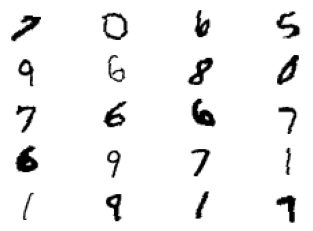

In [82]:
dataiter = iter(train_loader)
images, labels = dataiter.next()


misclssified_images_group = []
norm_arg = 'group'
Net = network_model(norm_arg)
model =  Net.to(device)
for index in range(1, 1000):
    
    label = int(labels[index])

    image = torch.unsqueeze(images[index], 0).to(device)
    
    prediction = model(image)
    prediction = prediction.squeeze(-1)
    prediction = prediction.squeeze(-1)
    prediction = int(torch.argmax(prediction))
    #print("prediction",prediction)
    #print("label",label)
    if(prediction != label):
      misclssified_images_group.append(image)
    
    if(len(misclssified_images_group)>=20):
      break;
    
figure = plt.figure()
num_of_images = 20
#misclssified_images_batch = misclssified_images_batch.numpy()
for index in range(1, num_of_images + 1):
    plt.subplot(5, 4, index)
    plt.axis('off')
    image = misclssified_images_group[index-1]
    image = image.cpu().numpy()
    #print("test",misclssified_images_batch[index].size())
    plt.imshow(image.squeeze(), cmap='gray_r')